# 프로젝트: ResNet 제거 연구 (ResNet Ablation Study)

프로젝트 개요:

ResNet (Residual Network)의 핵심 구성 요소인 **skip connection**이 모델 성능에 미치는 영향을 분석하는 **ablation study**이다.

**ResNet-34/50**과 동일한 레이어 구조를 가지지만 skip connection이 없는 **PlainNet-34/50**을 구현하고, 두 모델을 동일한 조건에서 학습시켜 검증 정확도(validation accuracy)와 검증 손실(validation loss)을 비교한다.이를 통해 skip connection이라는 단일 요소가 딥러닝 모델의 **학습 안정성과 성능에 어떤 결정적인 역할을 하는지 확인**할 수 있다.  

실험은 224x224 크기의 이미지 데이터셋(예: OxfordIIITPet)을 사용하며, PyTorch와 Google Colab 환경에서 진행했으며, 본 노트북 말미에 결과를 분석했다.

## 1. 라이브러리 불러오기 & 경로 설정

In [ ]:
!pip install torchinfo
# 이미 한번 실행했다면 건너뛰어도 됨

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

# Helper/utility libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

print("⋆⭒˚.⋆🪐 ⋆⭒˚.⋆")

⋆⭒˚.⋆🪐 ⋆⭒˚.⋆


In [ ]:
# 저장 경로
home_dir = '/content/drive/MyDrive/aiffel_rs_16/Ex03/'

## 2. 공통 함수 정의

### 2-1. 시각화 관련 함수 정의

In [ ]:
def show_sample_images(dataloader, num_images=8):
    """데이터셋에서 샘플 이미지 시각화 함수"""
    # 클래스 이름 (37개 품종)
    classes = [
        'Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound',
        'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair',
        'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter',
        'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin',
        'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland',
        'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard',
        'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx',
        'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier'
    ]

    # 배치 하나 가져오기
    images, labels = next(iter(dataloader))

    # 정규화 해제 (시각화용)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # 정규화 해제
        img = images[i] * std + mean
        img = torch.clamp(img, 0, 1)  # [0, 1] 범위로 제한
        img = img.permute(1, 2, 0).numpy()

        axes[i].imshow(img)
        axes[i].set_title(f"{classes[labels[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### 2-2. 모델 훈련 관련 함수 정의

In [ ]:
def set_seed(seed=42):
    """
    재현성(Reproducibility)을 위해 무작위 연산의 시드를 고정하는 함수

    Python, NumPy, PyTorch 및 CuDNN의 난수 생성기를 고정하여
    가중치 초기화와 데이터 셔플링 결과가 매 실행마다 동일하게 유지되도록 한다.

    Args:
        seed (int, optional): 고정할 시드 번호. 기본값은 42.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f">>> Seed fixed to {seed}")

In [ ]:
# 학습 함수
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    에포크 단위 학습 함수
    model: 학습할 모델
    dataloader: 학습 데이터를 배치(Batch) 단위로 공급
    criterion: 손실 함수 (예: CrossEntropyLoss)
    optimizer: 가중치를 업데이트할 최적화 알고리즘 (예: Adam)
    device: GPU 또는 CPU
    """
    # 모델을 학습 모드로 변경
    # Dropout이나 Batch Normalization처럼 학습/평가 시 동작이 다른 층들을 위해 필수적
    model.train()
    running_loss = 0.0 # 한 에포크 동안의 전체 손실 합계
    correct = 0 # 맞게 예측한 샘플 수
    total = 0 # 전체 샘플 수

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # 순전파 (Forward pass)
        optimizer.zero_grad() # 이전 배치에서 계산된 기울기(Gradient) 초기화
        outputs = model(images) # 순전파: 모델에 이미지를 넣어 예측값 계산
        loss = criterion(outputs, labels) # Loss 계산: 정답과 예측값의 차이 측정

        # 역전파 (Backward pass)
        loss.backward() # 기울기 계산 (Backpropagation)
        optimizer.step() # 계산된 기울기 바탕으로 가중치 업데이트

        # 실시간 통계 계산
        # loss.item()은 배치 평균 손실이므로 배치 크기를 곱해 전체 손실 합산
        running_loss += loss.item() * images.size(0)

        # 모델의 출력값 중 가장 높은 확률을 가진 인덱스를 예측값으로 선택
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) # 처리한 이미지 개수 누적
        correct += (predicted == labels).sum().item() # 정답 개수 누적

    # 에포크 최종 손실 및 정확도 계산
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 검증 함수
def validate(model, dataloader, criterion, device):
    """
    검증 데이터 평가 함수
    학습된 모델을 검증 데이터셋으로 평가하여 성능을 측정한다.
    이 단계에서는 가중치 업데이트(학습)를 수행하지 않는다.
    """
    # 모델을 평가 모드로 전환
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # 기울기 계산 비활성화 (메모리 절약 및 속도 향상)
    # 이 단계에서는 역전파 안함!!
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            # 순전파만 수행
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 통계 계산
            running_loss += loss.item() * images.size(0)

            # 예측값 결정
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 전체 학습 함수
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, save_path=None):
    """
    모델 학습 및 history를 기록하는 함수
    model: 학습시킬 신경망 모델 (ResNet 등)
    train_loader: 학습 데이터 로더
    val_loader: 검증 데이터 로더
    num_epochs: 전체 데이터를 몇 번 반복해서 학습할지 설정
    lr: 학습률 (Learning Rate)
    save_path: 최적의 성능을 보인 가중치(.pth)를 저장할 경로
    """
    # 장치 설정 (GPU/CPU) 및 손실함수, 옵티마이저 정의
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0 # 가장 높은 validation accuracy를 저장

    print(f"\n학습 시작 (Epochs: {num_epochs}, LR: {lr})")
    if save_path:
        print(f"Best 모델 저장 경로: {save_path}")
    print("=" * 80)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # History 기록
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - start_time # Epoch당 학습 시간 측정

        # 결과 출력
        print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%", end="")

        # Best model 체크 및 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(" (★ Best!)", end="") # 최고 성능 갱신 표시

            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f" → 저장: {save_path}", end="")

        print()  # 학습 로그 가독성을 위한 줄바꿈
        print("-" * 80)

    print(f"\n학습 완료! Best Validation Accuracy: {best_val_acc:.2f}%")
    if save_path:
        print(f"Best 모델 저장 위치: {save_path}")
    print("=" * 80)

    return history # 시각화(Loss/Acc 그래프)를 위해 기록된 데이터 반환

In [ ]:
# 결과 시각화 함수
def plot_history(history_resnet, history_plain, save_path=None):
    """두 모델의 학습 결과 비교 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history_resnet['train_loss']) + 1)

    # Loss 그래프
    axes[0].plot(epochs, history_resnet['train_loss'], 'b-', label='ResNet-34 Train', linewidth=2)
    axes[0].plot(epochs, history_resnet['val_loss'], 'b--', label='ResNet-34 Val', linewidth=2)
    axes[0].plot(epochs, history_plain['train_loss'], 'r-', label='PlainNet-34 Train', linewidth=2)
    axes[0].plot(epochs, history_plain['val_loss'], 'r--', label='PlainNet-34 Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy 그래프
    axes[1].plot(epochs, history_resnet['train_acc'], 'b-', label='ResNet-34 Train', linewidth=2)
    axes[1].plot(epochs, history_resnet['val_acc'], 'b--', label='ResNet-34 Val', linewidth=2)
    axes[1].plot(epochs, history_plain['train_acc'], 'r-', label='PlainNet-34 Train', linewidth=2)
    axes[1].plot(epochs, history_plain['val_acc'], 'r--', label='PlainNet-34 Val', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"그래프 저장: {save_path}")

    plt.show()

## 3. ResNet Block 구현

이 단계에서는 Kaiming He 외 3인이 발표한 [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/pdf/1512.03385) 논문을 참고한다.

ResNet Block 구현을 위해 위 논문에 등장한 아래 Table 1 을 다시 보면, **ResNet-34**는 conv1을 제외한 나머지 4개 stage(conv2_x ~ conv5_x)마다 각각 3×3 필터 2개로 이루어진 **BasicBlock**을 3개, 4개, 6개, 3개씩 쌓아 구성되어 있다.  

**ResNet-50**은 ResNet-34와 stage별 **블록 개수는 동일하지만([3, 4, 6, 3])**, 블록 유형이 **BottleneckBlock**으로, 1×1 conv → 3×3 conv → 1×1 conv 구조를 가지며 마지막 1×1 conv에서 채널을 4배 확장(expansion=4)한다.

<center>
<img width="1197" height="472" alt="Image" src="https://github.com/user-attachments/assets/4bf77fb7-35a6-4622-9f4a-b3d5666090d1" />
</center>

### 3-1. Basic Block 클래스 정의



In [ ]:
class BasicBlock(nn.Module):
    """
    ResNet-34에서 사용되는 Basic Block 클래스
    구조: 3x3 conv -> BN -> ReLU -> 3x3 conv -> BN -> (+skip) -> ReLU
    """
    expansion = 1 #출력 채널이 입력 채널과 동일

    def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
      """
      Args:
        in_channels: 입력 채널 수
        out_channels: 출력 채널 수 (expansion 적용 전)
        stride: 첫 번째 conv이 stride (downsampling용)
        use_skip: skip connection 사용 여부 (False면 PlainNet)
      """
      super().__init__()
      self.use_skip = use_skip

      # 첫 번째 3x3 conv (stride 적용 가능)
      self.conv1 = nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)

      # 두 번째 3x3 conv (항상 stride=1)
      self.conv2 = nn.Conv2d(out_channels, out_channels,
                             kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)

      self.relu = nn.ReLU(inplace=True)

      # Shortcut connection (입력과 출력의 차원이 다를 때 사용)
      if stride != 1 or in_channels != out_channels * self.expansion:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_channels, out_channels * self.expansion,
                        kernel_size=1, stride=stride, bias=False
                        ),
              nn.BatchNorm2d(out_channels * self.expansion)
          )
      else:
        self.shortcut = nn.Identity() # 차원이 같으면 그대로 통과


    def forward(self, x):
      identity = x

      # 주 연산 경로 (Main path)
      out = self.conv1(x) # 첫 번째 conv
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out) # 두 번째 conv
      out = self.bn2(out)

      # Skip connection (ResNet) vs No skip (PlainNet)
      if self.use_skip:
        identity = self.shortcut(identity) # 차원 맞추기 (필요시)
        out += identity # 원소별 합

      out = self.relu(out) # 최종 ReLU 적용

      return out

### 3-2. Bottleneck Block 클래스 정의

In [ ]:
class BottleneckBlock(nn.Module):
  """
  ResNet-50/101/152에서 사용되는 Blottle Block 클래스
  구조: 1x1 conv -> BN -> ReLU -> 3x3 conv -> BN -> ReLU -> 1x1 conv -> BN -> (+skip) -> ReLU
  """
  expansion = 4 # 마지막 1x1 conv에서 채널을 4배 확장

  def __init__(self, in_channels, out_channels, stride=1, use_skip=True):
    """
    Args
      in_channels: 입력 채널 수
      out_channels: bottleneck 중간 채널 수 (최종 출력은 out_channels * 4)
      stride: 두 번째 3x3 conv의 stride (downsampling용)
      use_skip: skip connection 사용 여부 (False면 PlainNet)
    """
    super().__init__()
    self.use_skip = use_skip

    # 1x1 conv (channel reduction)
    self.conv1 = nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    # 3x3 conv (stride 적용 가능)
    self.conv2 = nn.Conv2d(out_channels, out_channels,
                          kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    # 1x1 conv (channel expansion: out_channels -> out_channels * 4)
    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                          kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

    self.relu = nn.ReLU(inplace=True)

    # Shortcut connection
    if stride != 1 or in_channels != out_channels * self.expansion:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * self.expansion,
                    kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * self.expansion)
      )
    else:
      self.shortcut = nn.Identity() # 차원이 같으면 그대로 통과

  def forward(self, x):
    identity = x

    # 주 연산 경로 (Main path)
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    # Skip connection (ResNet) vs No skip (PlainNet)
    if self.use_skip:
      identity = self.shortcut(identity) # 차원 맞추기 (필요시)
      out += identity # 원소별 합

    out = self.relu(out) # 최종 ReLU 적용

    return out

### 3-3. ResNet 모델 클래스 정의

앞서 만든 BasicBlock과 BottleneckBlock을 stage별로 쌓아서 ResNet-34/50과 PlainNet-34/50을 모두 만들 수 있는 ResNet 클래스를 정의한다.

In [ ]:
class ResNet(nn.Module):
    """
    ResNet 전체 모델 클래스
    ResNet-34, ResNet-50, PlainNet-34, PlainNet-50 모두 생성 가능
    """
    def __init__(self, block, num_blocks_list, num_classes=1000, use_skip=True):
        """
        Args:
            block: BasicBlock 또는 BottleneckBlock 클래스
            num_blocks_list: 각 stage의 블록 개수 [conv2_x, conv3_x, conv4_x, conv5_x]
                           예: [3, 4, 6, 3] (ResNet-34, ResNet-50 공통)
            num_classes: 출력 클래스 개수 (ImageNet=1000, CIFAR-10=10 등)
            use_skip: skip connection 사용 여부 (False면 PlainNet)
        """
        super().__init__()
        self.in_channels = 64  # 현재 채널 수 (stage 진행하면서 변함)
        self.use_skip = use_skip

        # conv1: Initial layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # 출력: 224x224 -> 112x112 (conv) -> 56x56 (pooling)

        # conv2_x: 첫 번째 stage
        # 56x56, stride=1 유지 (downsampling 없음)
        self.conv2_x = self._make_stage(block, 64, num_blocks_list[0], stride=1)

        # conv3_x: 두 번째 stage
        # 56x56 -> 28x28 (첫 블록에서 stride=2)
        self.conv3_x = self._make_stage(block, 128, num_blocks_list[1], stride=2)

        # conv4_x: 세 번째 stage
        # 28x28 -> 14x14 (첫 블록에서 stride=2)
        self.conv4_x = self._make_stage(block, 256, num_blocks_list[2], stride=2)

        # conv5_x: 네 번째 stage
        # 14x14 -> 7x7 (첫 블록에서 stride=2)
        self.conv5_x = self._make_stage(block, 512, num_blocks_list[3], stride=2)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 7x7 -> 1x1
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_stage(self, block, out_channels, num_blocks, stride):
        """
        하나의 stage (conv2_x, conv3_x 등)를 만드는 함수

        Args:
            block: BasicBlock 또는 BottleneckBlock
            out_channels: 이 stage의 출력 채널 (expansion 적용 전)
            num_blocks: 이 stage에 쌓을 블록 개수
            stride: 첫 번째 블록의 stride (downsampling용)

        Returns:
            nn.Sequential: 블록들을 순차적으로 쌓은 stage
        """
        layers = []

        # 첫 번째 블록: stride 적용 (downsampling 가능)
        layers.append(block(self.in_channels, out_channels, stride=stride, use_skip=self.use_skip))

        # 채널 수 업데이트 (다음 블록의 입력 채널)
        self.in_channels = out_channels * block.expansion

        # 나머지 블록들: stride=1 (해상도 유지)
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, use_skip=self.use_skip))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: 입력 이미지 [batch, 3, 224, 224]

        Returns:
            출력 logits [batch, num_classes]
        """
        # Initial convolution
        x = self.conv1(x)           # [batch, 64, 56, 56]

        # Residual stages
        x = self.conv2_x(x)         # [batch, 64 or 256, 56, 56]
        x = self.conv3_x(x)         # [batch, 128 or 512, 28, 28]
        x = self.conv4_x(x)         # [batch, 256 or 1024, 14, 14]
        x = self.conv5_x(x)         # [batch, 512 or 2048, 7, 7]

        # Global average pooling + FC
        x = self.avgpool(x)         # [batch, 512 or 2048, 1, 1]
        x = torch.flatten(x, 1)     # [batch, 512 or 2048]
        x = self.fc(x)              # [batch, num_classes]

        return x

### 3-4. 빌더 함수 정의

In [ ]:
def build_resnet(model_type='resnet34', num_classes=1000, use_skip=True):
    """
    ResNet 또는 PlainNet 모델 생성 함수

    Args:
        model_type: 'resnet34', 'resnet50' 중 선택
        num_classes: 출력 클래스 개수
        use_skip: True면 ResNet, False면 PlainNet

    Returns:
        ResNet 모델 인스턴스

    Examples:
        >>> model = build_resnet('resnet34', num_classes=10, use_skip=True)   # ResNet-34
        >>> model = build_resnet('resnet50', num_classes=10, use_skip=False)  # PlainNet-50
    """
    if model_type == 'resnet34':
        return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, use_skip)
    elif model_type == 'resnet50':
        return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, use_skip)
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Choose 'resnet34' or 'resnet50'")

### 3-5. 함수 테스트

- ResNet-34 파라미터: 21,797,672개 `==` PlainNet-34 파라미터 개수
- ResNet-50 파라미터: 25,557,032개 `==` PlainNet-50 파라미터 개수


Skip connection 연산은 파라미터를 추가하지 않기 때문에 PlainNet-34와 PlainNet-50 파라미터의 개수는 각각 대응되는 ResNet 파라미터의 개수와 같다.

In [ ]:
# ResNet-34 테스트
resnet_34_test = build_resnet('resnet34', num_classes=1000, use_skip=True)
summary(resnet_34_test, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [ ]:
# PlainNet-34 테스트
plainnet_34_test = build_resnet('resnet34', num_classes=1000, use_skip=False)
summary(plainnet_34_test, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [ ]:
# ResNet-50 테스트
resnet_50_test = build_resnet('resnet50', num_classes=1000, use_skip=True)
summary(resnet_50_test, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleneckBlock: 2-5              [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

In [ ]:
# PlainNet-50 테스트
plainnet_50_test = build_resnet('resnet50', num_classes=1000, use_skip=False)
summary(plainnet_50_test, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleneckBlock: 2-5              [1, 256, 56, 56]          16,896
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           12

## 4. 실험

### 4-1. 데이터 준비

모델 성능 평가 실험을 위한 기본 데이터로 Pytorch 에서 제공하는 [`OxfordIIIYPet`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet) 을 사용한다.  

Oxford-IIIT Pet 데이터셋은 옥스퍼드 대학교의 Visual Geometry Group(VGG)에서 제작한 반려동물 이미지 데이터셋으로, 고양이와 강아지의 품종을 구분하거나 이미지 내 위치를 파악하는 연구에 주로 사용된다.

In [ ]:
# 1. Train Transform: 학습 시에는 무작위성을 부여하여 변동성에 강하게 만든다.
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # 무작위 영역 크롭 후 224로 리사이즈
    transforms.RandomHorizontalFlip(p=0.5),             # 50% 확률로 좌우 반전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 밝기/대조 변형
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2. Test Transform: 평가 시에는 일관성을 위해 중앙을 기준으로 크롭한다.
test_transform = transforms.Compose([
    transforms.Resize(256),                          # 조금 더 크게 리사이즈 후
    transforms.CenterCrop(224),                      # 중앙 224x224만 추출
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터셋 다운로드 및 로드
print("OxfordIIITPet 데이터셋 다운로드 중 🐶...")
print("=" * 80)

# Train 데이터셋
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',      # train + validation 데이터
    target_types='category',
    download=True,
    transform=train_transform
)

# Test 데이터셋
test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='test',
    target_types='category',
    download=True,
    transform=test_transform
)

OxfordIIITPet 데이터셋 다운로드 중 🐶...


100%|██████████| 792M/792M [00:28<00:00, 27.9MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 13.3MB/s]


In [ ]:
# Train 데이터를 train/validation으로 분할 (8:2)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print("\n데이터셋 정보:")
print("=" * 80)
print(f"Train 데이터: {len(train_subset):,}장")
print(f"Validation 데이터: {len(val_subset):,}장")
print(f"Test 데이터: {len(test_dataset):,}장")
print(f"총 클래스 수: 37개 (강아지/고양이 품종)")
print(f"이미지 크기: 224x224x3")
print("=" * 80)


데이터셋 정보:
Train 데이터: 2,944장
Validation 데이터: 736장
Test 데이터: 3,669장
총 클래스 수: 37개 (강아지/고양이 품종)
이미지 크기: 224x224x3


In [ ]:
# 하이퍼파라미터 설정
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
NUM_CLASSES = 37  # OxfordIIITPet

In [ ]:
# DataLoader 생성
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True, # GPU로 데이터를 빠르게 복사 (코랩 GPU 환경 필수)
    prefetch_factor=2 # CPU가 GPU 학습 중에 다음 데이터를 미리 준비
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2
)

print("=" * 80)
print(f"\nDataLoader 정보:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print("=" * 80)


DataLoader 정보:
Batch size: 128
Train batches: 23
Validation batches: 6
Test batches: 29



샘플 이미지 시각화:


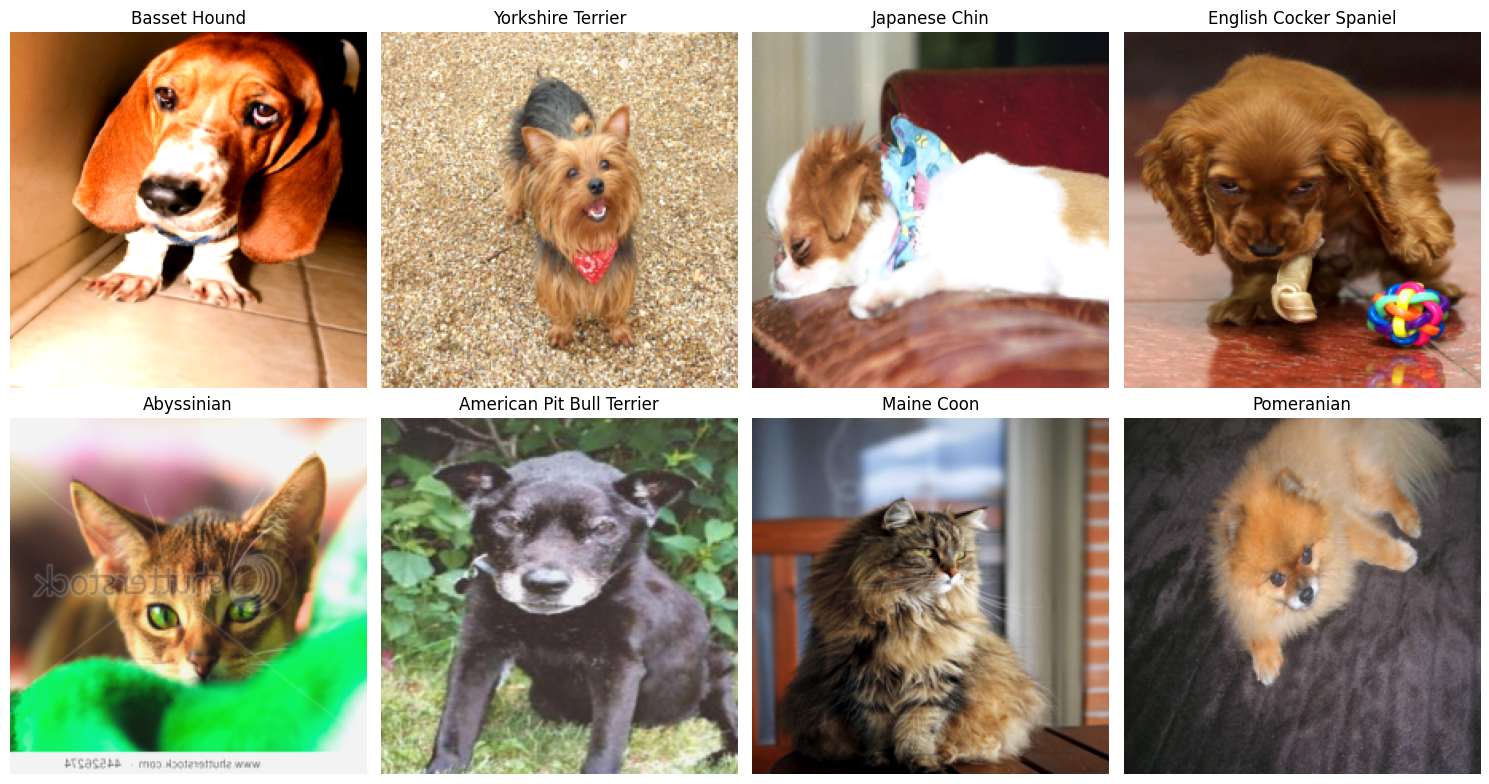


데이터 준비 완료! 🐶🐱


In [ ]:
# 샘플 이미지 보기
print("\n샘플 이미지 시각화:")
show_sample_images(train_loader, num_images=8)
print("=" * 80)

print("\n데이터 준비 완료! 🐶🐱")
print("=" * 80)

### 4-2. 모델 훈련

In [ ]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("=" * 80)

Using device: cuda
GPU: Tesla T4


#### 4-2-1. ResNet-34 vs. PlainNet-34 훈련

>>> Seed fixed to 42

[1] ResNet-34 학습 시작

학습 시작 (Epochs: 30, LR: 0.001)
Best 모델 저장 경로: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt


Epoch [1/30] (29.2s)
  Train Loss: 3.8360 | Train Acc: 4.28%
  Val Loss: 75.7752 | Val Acc: 2.72% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [2/30] (29.9s)
  Train Loss: 3.5391 | Train Acc: 6.15%
  Val Loss: 3.8260 | Val Acc: 5.03% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [3/30] (30.4s)
  Train Loss: 3.3921 | Train Acc: 8.08%
  Val Loss: 3.4463 | Val Acc: 7.74% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [4/30] (29.2s)
  Train Loss: 3.3021 | Train Acc: 9.85%
  Val Loss: 3.4290 | Val Acc: 8.29% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [5/30] (30.3s)
  Train Loss: 3.2334 | Train Acc: 11.45%
  Val Loss: 3.4885 | Val Acc: 6.93%
--------------------------------------------------------------------------------


Epoch [6/30] (29.0s)
  Train Loss: 3.2086 | Train Acc: 11.79%
  Val Loss: 3.6456 | Val Acc: 7.61%
--------------------------------------------------------------------------------


Epoch [7/30] (29.2s)
  Train Loss: 3.1199 | Train Acc: 13.72%
  Val Loss: 4.1783 | Val Acc: 8.97% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [8/30] (31.1s)
  Train Loss: 3.0408 | Train Acc: 15.18%
  Val Loss: 3.6194 | Val Acc: 11.41% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [9/30] (30.0s)
  Train Loss: 2.9799 | Train Acc: 15.73%
  Val Loss: 3.1167 | Val Acc: 13.99% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [10/30] (30.4s)
  Train Loss: 2.9423 | Train Acc: 17.39%
  Val Loss: 3.3250 | Val Acc: 12.09%
--------------------------------------------------------------------------------


Epoch [11/30] (31.3s)
  Train Loss: 2.8560 | Train Acc: 18.78%
  Val Loss: 3.6181 | Val Acc: 11.41%
--------------------------------------------------------------------------------


Epoch [12/30] (31.4s)
  Train Loss: 2.7615 | Train Acc: 22.04%
  Val Loss: 3.6983 | Val Acc: 12.36%
--------------------------------------------------------------------------------


Epoch [13/30] (31.3s)
  Train Loss: 2.7151 | Train Acc: 22.83%
  Val Loss: 3.1553 | Val Acc: 14.67% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [14/30] (31.0s)
  Train Loss: 2.6469 | Train Acc: 24.22%
  Val Loss: 2.9515 | Val Acc: 16.44% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [15/30] (33.9s)
  Train Loss: 2.5859 | Train Acc: 26.15%
  Val Loss: 3.1688 | Val Acc: 18.61% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [16/30] (31.1s)
  Train Loss: 2.4644 | Train Acc: 28.50%
  Val Loss: 2.9898 | Val Acc: 19.97% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [17/30] (32.1s)
  Train Loss: 2.4086 | Train Acc: 30.37%
  Val Loss: 3.3156 | Val Acc: 14.67%
--------------------------------------------------------------------------------


Epoch [18/30] (29.2s)
  Train Loss: 2.3700 | Train Acc: 30.23%
  Val Loss: 2.8667 | Val Acc: 23.23% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [19/30] (30.5s)
  Train Loss: 2.2661 | Train Acc: 32.88%
  Val Loss: 2.9013 | Val Acc: 23.51% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [20/30] (34.7s)
  Train Loss: 2.1804 | Train Acc: 36.51%
  Val Loss: 2.7149 | Val Acc: 28.40% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [21/30] (30.8s)
  Train Loss: 2.0729 | Train Acc: 38.01%
  Val Loss: 2.8928 | Val Acc: 23.64%
--------------------------------------------------------------------------------


Epoch [22/30] (30.2s)
  Train Loss: 1.9560 | Train Acc: 42.09%
  Val Loss: 2.6658 | Val Acc: 28.40%
--------------------------------------------------------------------------------


Epoch [23/30] (29.5s)
  Train Loss: 1.9355 | Train Acc: 42.29%
  Val Loss: 2.9175 | Val Acc: 25.68%
--------------------------------------------------------------------------------


Epoch [24/30] (32.4s)
  Train Loss: 1.8358 | Train Acc: 44.77%
  Val Loss: 2.7807 | Val Acc: 27.72%
--------------------------------------------------------------------------------


Epoch [25/30] (32.4s)
  Train Loss: 1.7261 | Train Acc: 47.89%
  Val Loss: 3.2736 | Val Acc: 23.78%
--------------------------------------------------------------------------------


Epoch [26/30] (29.8s)
  Train Loss: 1.6756 | Train Acc: 49.05%
  Val Loss: 2.8846 | Val Acc: 25.54%
--------------------------------------------------------------------------------


Epoch [27/30] (30.9s)
  Train Loss: 1.5296 | Train Acc: 52.65%
  Val Loss: 2.6277 | Val Acc: 29.35% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------


Epoch [28/30] (35.0s)
  Train Loss: 1.4647 | Train Acc: 55.30%
  Val Loss: 3.0039 | Val Acc: 27.58%
--------------------------------------------------------------------------------


Epoch [29/30] (30.6s)
  Train Loss: 1.3653 | Train Acc: 57.98%
  Val Loss: 2.9654 | Val Acc: 27.45%
--------------------------------------------------------------------------------


Epoch [30/30] (30.9s)
  Train Loss: 1.2925 | Train Acc: 60.43%
  Val Loss: 2.7449 | Val Acc: 32.74% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
--------------------------------------------------------------------------------

학습 완료! Best Validation Accuracy: 32.74%
Best 모델 저장 위치: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34_best.pt
>>> Seed fixed to 42

[2] PlainNet-34 학습 시작

학습 시작 (Epochs: 30, LR: 0.001)
Best 모델 저장 경로: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt


Epoch [1/30] (29.3s)
  Train Loss: 3.7190 | Train Acc: 2.28%
  Val Loss: 3.8138 | Val Acc: 2.45% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [2/30] (30.4s)
  Train Loss: 3.6209 | Train Acc: 3.16%
  Val Loss: 4.7393 | Val Acc: 2.45%
--------------------------------------------------------------------------------


Epoch [3/30] (31.1s)
  Train Loss: 3.6185 | Train Acc: 2.72%
  Val Loss: 3.6238 | Val Acc: 3.40% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [4/30] (33.6s)
  Train Loss: 3.6099 | Train Acc: 2.96%
  Val Loss: 3.6149 | Val Acc: 2.58%
--------------------------------------------------------------------------------


Epoch [5/30] (28.4s)
  Train Loss: 3.6018 | Train Acc: 2.96%
  Val Loss: 3.8084 | Val Acc: 2.99%
--------------------------------------------------------------------------------


Epoch [6/30] (31.4s)
  Train Loss: 3.6072 | Train Acc: 3.02%
  Val Loss: 3.6077 | Val Acc: 3.12%
--------------------------------------------------------------------------------


Epoch [7/30] (31.6s)
  Train Loss: 3.5703 | Train Acc: 4.18%
  Val Loss: 4.4357 | Val Acc: 2.99%
--------------------------------------------------------------------------------


Epoch [8/30] (32.2s)
  Train Loss: 3.5178 | Train Acc: 4.86%
  Val Loss: 4.2563 | Val Acc: 2.58%
--------------------------------------------------------------------------------


Epoch [9/30] (32.1s)
  Train Loss: 3.4833 | Train Acc: 5.50%
  Val Loss: 3.7531 | Val Acc: 5.03% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [10/30] (31.2s)
  Train Loss: 3.4559 | Train Acc: 4.93%
  Val Loss: 3.6221 | Val Acc: 5.03%
--------------------------------------------------------------------------------


Epoch [11/30] (28.8s)
  Train Loss: 3.4281 | Train Acc: 5.33%
  Val Loss: 9.5883 | Val Acc: 3.80%
--------------------------------------------------------------------------------


Epoch [12/30] (28.9s)
  Train Loss: 3.3966 | Train Acc: 6.96%
  Val Loss: 3.9034 | Val Acc: 4.35%
--------------------------------------------------------------------------------


Epoch [13/30] (28.8s)
  Train Loss: 3.3638 | Train Acc: 7.20%
  Val Loss: 3.6730 | Val Acc: 4.35%
--------------------------------------------------------------------------------


Epoch [14/30] (28.8s)
  Train Loss: 3.3439 | Train Acc: 7.54%
  Val Loss: 3.8757 | Val Acc: 6.39% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [15/30] (30.6s)
  Train Loss: 3.3183 | Train Acc: 8.66%
  Val Loss: 3.4197 | Val Acc: 8.83% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [16/30] (30.8s)
  Train Loss: 3.3099 | Train Acc: 8.15%
  Val Loss: 3.8144 | Val Acc: 5.84%
--------------------------------------------------------------------------------


Epoch [17/30] (28.9s)
  Train Loss: 3.2748 | Train Acc: 9.38%
  Val Loss: 3.7963 | Val Acc: 4.48%
--------------------------------------------------------------------------------


Epoch [18/30] (28.2s)
  Train Loss: 3.2593 | Train Acc: 9.78%
  Val Loss: 3.4014 | Val Acc: 5.84%
--------------------------------------------------------------------------------


Epoch [19/30] (28.4s)
  Train Loss: 3.2403 | Train Acc: 9.41%
  Val Loss: 3.3634 | Val Acc: 7.74%
--------------------------------------------------------------------------------


Epoch [20/30] (28.2s)
  Train Loss: 3.2121 | Train Acc: 10.43%
  Val Loss: 3.8700 | Val Acc: 6.25%
--------------------------------------------------------------------------------


Epoch [21/30] (28.1s)
  Train Loss: 3.2127 | Train Acc: 10.16%
  Val Loss: 3.5673 | Val Acc: 8.15%
--------------------------------------------------------------------------------


Epoch [22/30] (28.4s)
  Train Loss: 3.2003 | Train Acc: 10.87%
  Val Loss: 5.6205 | Val Acc: 6.39%
--------------------------------------------------------------------------------


Epoch [23/30] (28.4s)
  Train Loss: 3.1765 | Train Acc: 10.39%
  Val Loss: 3.2941 | Val Acc: 9.38% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [24/30] (30.0s)
  Train Loss: 3.1414 | Train Acc: 11.24%
  Val Loss: 3.5863 | Val Acc: 8.02%
--------------------------------------------------------------------------------


Epoch [25/30] (28.5s)
  Train Loss: 3.1160 | Train Acc: 11.89%
  Val Loss: 3.3818 | Val Acc: 8.56%
--------------------------------------------------------------------------------


Epoch [26/30] (28.3s)
  Train Loss: 3.0940 | Train Acc: 13.01%
  Val Loss: 3.5510 | Val Acc: 10.19% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------


Epoch [27/30] (29.4s)
  Train Loss: 3.0949 | Train Acc: 13.21%
  Val Loss: 3.3784 | Val Acc: 8.15%
--------------------------------------------------------------------------------


Epoch [28/30] (28.1s)
  Train Loss: 3.0756 | Train Acc: 12.67%
  Val Loss: 4.3565 | Val Acc: 8.56%
--------------------------------------------------------------------------------


Epoch [29/30] (28.7s)
  Train Loss: 3.0577 | Train Acc: 14.23%
  Val Loss: 3.1965 | Val Acc: 8.70%
--------------------------------------------------------------------------------


Epoch [30/30] (28.7s)
  Train Loss: 3.0185 | Train Acc: 13.86%
  Val Loss: 3.3462 | Val Acc: 11.01% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt
--------------------------------------------------------------------------------

학습 완료! Best Validation Accuracy: 11.01%
Best 모델 저장 위치: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_34_best.pt

[3] 결과 시각화
그래프 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_34 vs plainnet_34_comparison.png


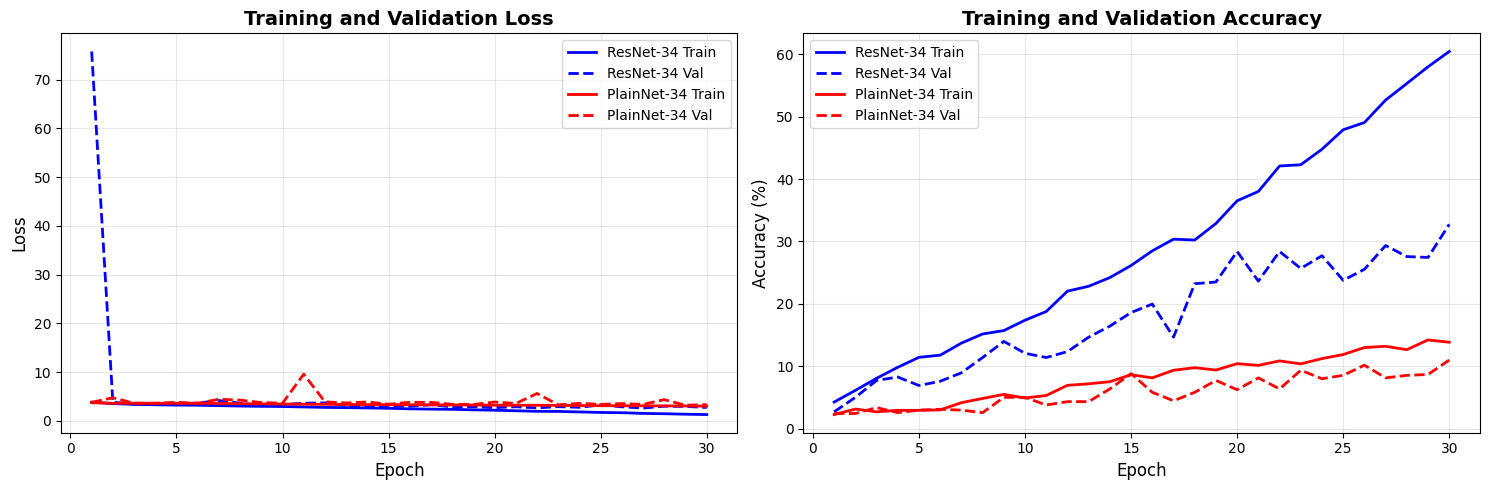


최종 결과 요약
ResNet-34 최고 Validation Accuracy: 32.74%
PlainNet-34 최고 Validation Accuracy: 11.01%
차이: 21.74%p

🐱 ResNet-34 vs. PlainNet-34 Ablation Study 완료!


In [ ]:
# 모델 1: ResNet-34 (use_skip=True)
set_seed(42) # 시드 고정
print("\n[1] ResNet-34 학습 시작")
print("=" * 80)
resnet_34 = build_resnet('resnet34', num_classes=NUM_CLASSES, use_skip=True) # 모델 선언 (필수!)
history_resnet_34 = train_model(resnet_34, train_loader, val_loader,
                                  num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
                                save_path=home_dir+'resnet_34_best.pt') # 최고 성능 낸 모델 매개변수 저장 경로 추가

# 모델 2: PlainNet-34 (use_skip=False)
set_seed(42) # 같은 시드 사용
print("\n[2] PlainNet-34 학습 시작")
print("=" * 80)
plainnet_34 = build_resnet('resnet34', num_classes=NUM_CLASSES, use_skip=False)
history_plain_34 = train_model(plainnet_34, train_loader, val_loader,
                                 num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
                               save_path=home_dir+'plain_34_best.pt')

# 결과 비교 시각화
print("\n[3] 결과 시각화")
print("=" * 80)
plot_history(history_resnet_34, history_plain_34, save_path=home_dir+'resnet_34 vs plainnet_34_comparison.png')

# 최종 결과 요약
print("\n" + "=" * 80)
print("최종 결과 요약")
print("=" * 80)
print(f"ResNet-34 최고 Validation Accuracy: {max(history_resnet_34['val_acc']):.2f}%")
print(f"PlainNet-34 최고 Validation Accuracy: {max(history_plain_34['val_acc']):.2f}%")
print(f"차이: {max(history_resnet_34['val_acc']) - max(history_plain_34['val_acc']):.2f}%p")
print("=" * 80)

print("\n🐱 ResNet-34 vs. PlainNet-34 Ablation Study 완료!")

In [ ]:
# 메모리 관리 (VRAM 비우기)
# 모델 매개변수를 별도로 저장했으므로 메모리에서 삭제하여 용량 확보
del resnet_34, plainnet_34
torch.cuda.empty_cache()
print("=" * 80)
print(">>> 🏁 GPU 메모리 정리 완료 (ResNet-50 실험 준비)")

>>> 🏁 GPU 메모리 정리 완료 (ResNet-50 실험 준비)


#### 4-2-2. ResNet-50 vs. PlainNet-50 훈련

>>> Seed fixed to 42

[1] ResNet-50 학습 시작

학습 시작 (Epochs: 30, LR: 0.001)
Best 모델 저장 경로: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt


Epoch [1/30] (36.1s)
  Train Loss: 4.0308 | Train Acc: 2.79%
  Val Loss: 3.6317 | Val Acc: 3.12% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [2/30] (39.0s)
  Train Loss: 3.6709 | Train Acc: 5.13%
  Val Loss: 4.0408 | Val Acc: 5.30% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [3/30] (40.3s)
  Train Loss: 3.5345 | Train Acc: 6.42%
  Val Loss: 3.4872 | Val Acc: 6.52% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [4/30] (38.8s)
  Train Loss: 3.4573 | Train Acc: 8.19%
  Val Loss: 6.2899 | Val Acc: 8.29% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [5/30] (39.0s)
  Train Loss: 3.3459 | Train Acc: 9.54%
  Val Loss: 3.3613 | Val Acc: 8.97% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [6/30] (39.6s)
  Train Loss: 3.3144 | Train Acc: 9.68%
  Val Loss: 3.8136 | Val Acc: 8.70%
--------------------------------------------------------------------------------


Epoch [7/30] (38.5s)
  Train Loss: 3.2308 | Train Acc: 11.04%
  Val Loss: 3.3450 | Val Acc: 10.73% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [8/30] (38.2s)
  Train Loss: 3.1597 | Train Acc: 13.04%
  Val Loss: 3.2519 | Val Acc: 11.96% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [9/30] (41.7s)
  Train Loss: 3.0941 | Train Acc: 14.74%
  Val Loss: 3.3024 | Val Acc: 11.28%
--------------------------------------------------------------------------------


Epoch [10/30] (38.9s)
  Train Loss: 3.0212 | Train Acc: 16.07%
  Val Loss: 3.3615 | Val Acc: 12.64% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [11/30] (39.3s)
  Train Loss: 2.9678 | Train Acc: 17.09%
  Val Loss: 3.2491 | Val Acc: 15.08% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [12/30] (39.0s)
  Train Loss: 2.9089 | Train Acc: 18.38%
  Val Loss: 3.1994 | Val Acc: 14.54%
--------------------------------------------------------------------------------


Epoch [13/30] (39.1s)
  Train Loss: 2.7696 | Train Acc: 21.03%
  Val Loss: 3.8117 | Val Acc: 9.65%
--------------------------------------------------------------------------------


Epoch [14/30] (37.7s)
  Train Loss: 2.7599 | Train Acc: 22.52%
  Val Loss: 2.9948 | Val Acc: 15.90% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [15/30] (39.9s)
  Train Loss: 2.6316 | Train Acc: 24.15%
  Val Loss: 3.8909 | Val Acc: 10.46%
--------------------------------------------------------------------------------


Epoch [16/30] (38.6s)
  Train Loss: 2.6417 | Train Acc: 23.30%
  Val Loss: 3.5957 | Val Acc: 12.77%
--------------------------------------------------------------------------------


Epoch [17/30] (38.8s)
  Train Loss: 2.5422 | Train Acc: 26.15%
  Val Loss: 2.7916 | Val Acc: 23.10% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [18/30] (39.2s)
  Train Loss: 2.4294 | Train Acc: 29.45%
  Val Loss: 3.0400 | Val Acc: 21.33%
--------------------------------------------------------------------------------


Epoch [19/30] (37.7s)
  Train Loss: 2.4202 | Train Acc: 28.97%
  Val Loss: 3.6189 | Val Acc: 17.39%
--------------------------------------------------------------------------------


Epoch [20/30] (38.7s)
  Train Loss: 2.2974 | Train Acc: 31.52%
  Val Loss: 2.8423 | Val Acc: 23.78% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [21/30] (38.3s)
  Train Loss: 2.2353 | Train Acc: 33.87%
  Val Loss: 3.3068 | Val Acc: 17.26%
--------------------------------------------------------------------------------


Epoch [22/30] (39.4s)
  Train Loss: 2.1854 | Train Acc: 34.92%
  Val Loss: 3.1925 | Val Acc: 21.47%
--------------------------------------------------------------------------------


Epoch [23/30] (38.9s)
  Train Loss: 2.1011 | Train Acc: 37.43%
  Val Loss: 3.3691 | Val Acc: 15.49%
--------------------------------------------------------------------------------


Epoch [24/30] (37.8s)
  Train Loss: 1.9859 | Train Acc: 38.72%
  Val Loss: 3.2252 | Val Acc: 25.41% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [25/30] (38.9s)
  Train Loss: 1.9596 | Train Acc: 40.83%
  Val Loss: 3.0216 | Val Acc: 21.06%
--------------------------------------------------------------------------------


Epoch [26/30] (38.2s)
  Train Loss: 1.8517 | Train Acc: 43.55%
  Val Loss: 3.0698 | Val Acc: 23.64%
--------------------------------------------------------------------------------


Epoch [27/30] (39.1s)
  Train Loss: 1.8849 | Train Acc: 42.56%
  Val Loss: 3.1785 | Val Acc: 24.18%
--------------------------------------------------------------------------------


Epoch [28/30] (38.0s)
  Train Loss: 1.7751 | Train Acc: 45.55%
  Val Loss: 3.5598 | Val Acc: 24.18%
--------------------------------------------------------------------------------


Epoch [29/30] (38.3s)
  Train Loss: 1.7219 | Train Acc: 48.17%
  Val Loss: 2.7731 | Val Acc: 31.25% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
--------------------------------------------------------------------------------


Epoch [30/30] (38.9s)
  Train Loss: 1.6339 | Train Acc: 49.69%
  Val Loss: 4.7536 | Val Acc: 19.57%
--------------------------------------------------------------------------------

학습 완료! Best Validation Accuracy: 31.25%
Best 모델 저장 위치: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50_best.pt
>>> Seed fixed to 42

[2] PlainNet-34 학습 시작

학습 시작 (Epochs: 30, LR: 0.001)
Best 모델 저장 경로: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt


Epoch [1/30] (33.1s)
  Train Loss: 3.7478 | Train Acc: 2.14%
  Val Loss: 3.6191 | Val Acc: 1.77% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [2/30] (37.9s)
  Train Loss: 3.6605 | Train Acc: 2.62%
  Val Loss: 3.6408 | Val Acc: 2.17% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [3/30] (37.4s)
  Train Loss: 3.6238 | Train Acc: 2.62%
  Val Loss: 3.6154 | Val Acc: 2.99% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [4/30] (37.0s)
  Train Loss: 3.6164 | Train Acc: 3.26%
  Val Loss: 3.9653 | Val Acc: 2.58%
--------------------------------------------------------------------------------


Epoch [5/30] (33.7s)
  Train Loss: 3.6029 | Train Acc: 3.40%
  Val Loss: 3.5844 | Val Acc: 2.99%
--------------------------------------------------------------------------------


Epoch [6/30] (36.6s)
  Train Loss: 3.5825 | Train Acc: 4.31%
  Val Loss: 3.5730 | Val Acc: 4.62% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [7/30] (34.4s)
  Train Loss: 3.5660 | Train Acc: 3.19%
  Val Loss: 3.5635 | Val Acc: 4.21%
--------------------------------------------------------------------------------


Epoch [8/30] (34.3s)
  Train Loss: 3.5660 | Train Acc: 3.80%
  Val Loss: 3.6880 | Val Acc: 2.99%
--------------------------------------------------------------------------------


Epoch [9/30] (33.0s)
  Train Loss: 3.5422 | Train Acc: 4.08%
  Val Loss: 3.6861 | Val Acc: 3.67%
--------------------------------------------------------------------------------


Epoch [10/30] (32.9s)
  Train Loss: 3.5346 | Train Acc: 4.21%
  Val Loss: 3.6557 | Val Acc: 3.53%
--------------------------------------------------------------------------------


Epoch [11/30] (35.3s)
  Train Loss: 3.5371 | Train Acc: 4.48%
  Val Loss: 3.6196 | Val Acc: 6.11% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [12/30] (34.2s)
  Train Loss: 3.4937 | Train Acc: 5.06%
  Val Loss: 3.6420 | Val Acc: 5.03%
--------------------------------------------------------------------------------


Epoch [13/30] (35.5s)
  Train Loss: 3.4825 | Train Acc: 5.91%
  Val Loss: 3.5476 | Val Acc: 4.89%
--------------------------------------------------------------------------------


Epoch [14/30] (32.5s)
  Train Loss: 3.4676 | Train Acc: 6.22%
  Val Loss: 3.5215 | Val Acc: 5.98%
--------------------------------------------------------------------------------


Epoch [15/30] (35.3s)
  Train Loss: 3.4266 | Train Acc: 5.98%
  Val Loss: 3.4982 | Val Acc: 5.30%
--------------------------------------------------------------------------------


Epoch [16/30] (32.6s)
  Train Loss: 3.4284 | Train Acc: 6.59%
  Val Loss: 3.6382 | Val Acc: 4.48%
--------------------------------------------------------------------------------


Epoch [17/30] (38.6s)
  Train Loss: 3.4188 | Train Acc: 7.10%
  Val Loss: 3.4828 | Val Acc: 5.57%
--------------------------------------------------------------------------------


Epoch [18/30] (34.8s)
  Train Loss: 3.3925 | Train Acc: 7.95%
  Val Loss: 3.7044 | Val Acc: 4.21%
--------------------------------------------------------------------------------


Epoch [19/30] (34.5s)
  Train Loss: 3.4235 | Train Acc: 7.54%
  Val Loss: 3.4779 | Val Acc: 7.07% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [20/30] (35.9s)
  Train Loss: 3.3762 | Train Acc: 7.71%
  Val Loss: 3.3903 | Val Acc: 7.61% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [21/30] (37.2s)
  Train Loss: 3.3743 | Train Acc: 7.24%
  Val Loss: 3.5280 | Val Acc: 8.02% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [22/30] (36.3s)
  Train Loss: 3.3373 | Train Acc: 7.88%
  Val Loss: 3.4746 | Val Acc: 5.43%
--------------------------------------------------------------------------------


Epoch [23/30] (32.5s)
  Train Loss: 3.3218 | Train Acc: 8.59%
  Val Loss: 3.5446 | Val Acc: 6.25%
--------------------------------------------------------------------------------


Epoch [24/30] (33.0s)
  Train Loss: 3.2881 | Train Acc: 9.17%
  Val Loss: 3.4231 | Val Acc: 6.79%
--------------------------------------------------------------------------------


Epoch [25/30] (34.8s)
  Train Loss: 3.2830 | Train Acc: 10.09%
  Val Loss: 3.5268 | Val Acc: 5.98%
--------------------------------------------------------------------------------


Epoch [26/30] (33.0s)
  Train Loss: 3.2755 | Train Acc: 9.85%
  Val Loss: 3.5590 | Val Acc: 6.39%
--------------------------------------------------------------------------------


Epoch [27/30] (34.5s)
  Train Loss: 3.2604 | Train Acc: 9.68%
  Val Loss: 3.5967 | Val Acc: 6.11%
--------------------------------------------------------------------------------


Epoch [28/30] (32.8s)
  Train Loss: 3.2630 | Train Acc: 9.71%
  Val Loss: 3.3271 | Val Acc: 7.61%
--------------------------------------------------------------------------------


Epoch [29/30] (33.7s)
  Train Loss: 3.2417 | Train Acc: 10.26%
  Val Loss: 3.3685 | Val Acc: 8.15% (★ Best!) → 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt
--------------------------------------------------------------------------------


Epoch [30/30] (34.8s)
  Train Loss: 3.2411 | Train Acc: 10.46%
  Val Loss: 3.4363 | Val Acc: 6.66%
--------------------------------------------------------------------------------

학습 완료! Best Validation Accuracy: 8.15%
Best 모델 저장 위치: /content/drive/MyDrive/aiffel_rs_16/Ex03/plain_50_best.pt

[3] 결과 시각화
그래프 저장: /content/drive/MyDrive/aiffel_rs_16/Ex03/resnet_50 vs_plainnet_50 comparison.png


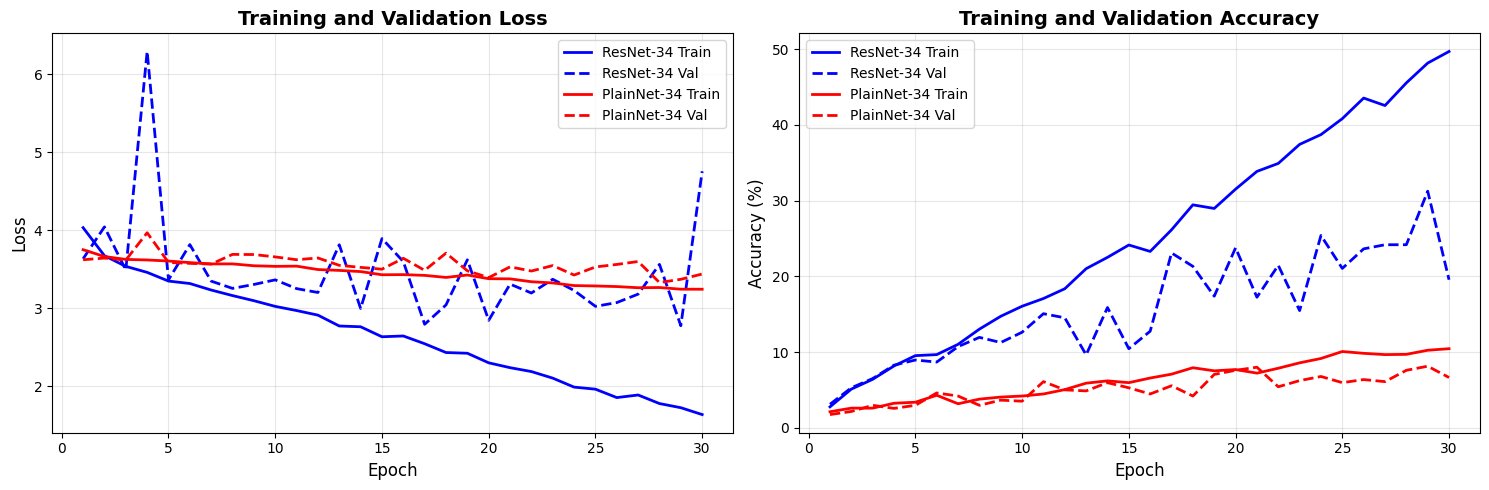


최종 결과 요약
ResNet-50 최고 Validation Accuracy: 31.25%
PlainNet-50 최고 Validation Accuracy: 8.15%
차이: 23.10%p

🐶 ResNet-50 vs. PlainNet-50 Ablation Study 완료!


In [ ]:
# 모델 3: ResNet-50 (use_skip=True)
set_seed(42)
print("\n[1] ResNet-50 학습 시작")
print("=" * 80)
resnet_50 = build_resnet('resnet50', num_classes=NUM_CLASSES, use_skip=True)
history_resnet_50 = train_model(resnet_50, train_loader, val_loader,
                                  num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
                                save_path=home_dir+'resnet_50_best.pt')

# 모델 4: PlainNet-50 (use_skip=False)
set_seed(42)
print("\n[2] PlainNet-50 학습 시작") # PlainNet-34 오타 수정
print("=" * 80)
plainnet_50 = build_resnet('resnet50', num_classes=NUM_CLASSES, use_skip=False)
history_plain_50 = train_model(plainnet_50, train_loader, val_loader,
                                 num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
                               save_path=home_dir+'plain_50_best.pt')

# 결과 비교 시각화
print("\n[3] 결과 시각화")
print("=" * 80)
plot_history(history_resnet_50, history_plain_50, save_path=home_dir+'resnet_50 vs_plainnet_50 comparison.png')

# 최종 결과 요약
print("\n" + "=" * 80)
print("최종 결과 요약")
print("=" * 80)
print(f"ResNet-50 최고 Validation Accuracy: {max(history_resnet_50['val_acc']):.2f}%")
print(f"PlainNet-50 최고 Validation Accuracy: {max(history_plain_50['val_acc']):.2f}%")
print(f"차이: {max(history_resnet_50['val_acc']) - max(history_plain_50['val_acc']):.2f}%p")
print("=" * 80)

print("\n🐶 ResNet-50 vs. PlainNet-50 Ablation Study 완료!")

*오타 정정: 학습 로그에서 `PlainNet-34 학습 시작`이 아니고 ❌ `PlainNet-50 학습 시작`이 맞음 ✅

## 5. 정리

본 실험에서는 **ResNet**의 핵심 구조인 **Skip Connection의 효과를 검증하기 위해 Ablation Study를 수행**하였다. 공정한 비교를 위해 Residual Block이 제거된 **PlainNet**을 대조군으로 설정했으며, 동일한 시드(Seed), 학습 횟수(Epoch), 그리고 레이어 깊이로 통제하며 Oxford-IIIT Pet 데이터셋에 대한 이미지 분류 성능을 측정했다. 실험 결과에 대한 주요 분석 및 해석은 다음과 같다.

### 5-1. ResNet-34 vs. PlainNet-34 Ablation Study

**1. 최종 성능 비교**  
최고 검증 정확도(Validation Accuracy)는 ResNet-34가 32.74%, PlainNet-34가 11.01%를 기록하여, **21.74%p**라는 매우 큰 성능 격차가 발생했다. 이는 깊은 신경망 학습에서 잔차 연결 구조가 필수적임을 시사한다.  

**2. 학습 양상 분석**  

- 손실(Loss) 곡선:  
  - ResNet-34는 학습 초기부터 손실이 급격히 감소하며 빠르게 수렴하는 모습을 보였다.  
  - 반면, PlainNet-34는 ResNet-34와 비슷한 초기 손실 감소는 보였으나, 빠르게 정체(Plateau)되어 최적점에 도달하지 못했다.  

- 정확도(Accuracy) 곡선:  
  - ResNet-34는 학습 에포크(Epoch)가 진행될수록 학습 및 검증 정확도가 꾸준히 상승하며 안정적인 학습 능력을 입증했다.  
  - PlainNet-34는 훈련 정확도와 검증 정확도 모두 낮은 수준에서 성능 개선이 거의 이루어지지 않았다. 특히 검증 정확도 곡선은 변동성이 크고 불안정한 양상을 보였다.  

<center>
<img width="4464" height="1464" alt="Image" src="https://github.com/user-attachments/assets/990e7ee8-2013-4b78-ac0d-8afce563b342" />
</center>

### 5-2. ResNet-50 vs. PlainNet-50 Ablation study

**1. 최종 성능 비교**  
이 경우에도 최고 검증 정확도(Validation Accuracy)는 ResNet-50이 31.25%, PlainNet-50이 8.15%를 기록하여, 23.10%p라는 매우 큰 성능 격차가 발생하여 모델의 깊이가 깊어질수록 잔차 연결 구조가 더욱 필수적임을 보여준다.  
다만 한 가지 짚고 넘어갈 것은 더 깊은 층을 가진 ResNet-50의 성능이 ResNet-34의 성능 보다 낮게 나타나는 점이다. 이는 모델의 복잡도에 비해 학습 데이터가 부족하여 과적합(Overfitting)이 발생한 것으로 판단된다.

**2. 학습 양상 분석**  

- 손실(Loss) 곡선:  
  - ResNet-50의 훈련 손실(파란색 실선)은 에포크가 진행될수록 꾸준히 감소하며 안정적인 학습을 나타낸다. 검증 손실(파란색 점선)은 다소 변동성이 있지만 전반적인 감소 추세를 보인다.  
  - PlainNet-50의 훈련 및 검증 손실(빨간색 실/점선)은 학습 전반에 걸쳐 거의 변화가 없거나 매우 불안정한 모습을 보이며, 모델이 데이터를 학습하는 데 실패했음을 뜻한다.

- 정확도(Accuracy) 곡선:  
  - ResNet-50은 학습 에포크(Epoch)가 진행될수록 학습 및 검증 정확도가 꾸준히 상승하는 안정적인 학습 양상을 보였다.  
  - PlainNet-50은 훈련 정확도와 검증 정확도 모두 낮은 수준(10% 내외)에서 성능 개선이 거의 이루어지지 않았다. 이는 모델이 무작위 추측 수준(Random Guessing - 본 실험에서는 100/3.7% 수준)에서 벗어나지 못했음을 나타낸다.

<center>
<img width="4464" height="1464" alt="Image" src="https://github.com/user-attachments/assets/96c7b7ac-2fab-403a-85c2-73635f38cd52" />
</center>

### 5-3. 종합

**Degradation problem**
*   ResNet은 깊어져도 학습되지만, PlainNet은 깊어질수록 못 배움  

**학습 안정성**:

*   실험 <4-2-1> 기준으로 ResNet-34는 안정적인 학습 곡선을 보인 반면, PlainNet-34는 불안정한 검증 성능을 보였다.
*   Skip connection이 gradient flow를 안정화시킨다는 것을 알 수 있었음





## 6. 회고

- 처음으로 논문 구현이라는 걸 해봤는데 기존 코드가 있었음에도 논문에 등장한 개념을 코드로 구현하는 건 또 다른 문제임을 실감했다.
- `train_model` 함수 내에서 자체적으로 모델 인스턴스를 생성하는 방식으로도 코드 수정을 해볼 수 있지 않을까 한다.
- 시간 관계상 모델 튜닝을 도전하지 않은 점과 **과적합 방지 기법**을 쓰지 않은 점이  아쉽다.  
  - 예를 들면 `optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)` 같은 최적화 알고리즘 변경과 학습률, 혹은 Scheduler 시도 등
  - 과적화 방지 기법으로는 Weight Decay, Dropout Early stopping 등
- 참고 문헌:  
  - Pytorch Module code - torchvision.models.resnet ([link](https://docs.pytorch.org/vision/main/_modules/torchvision/models/resnet.html))
  - Deep Residual Learning for Image Recognition ([paper](https://arxiv.org/pdf/1512.03385)) | ([github](https://github.com/KaimingHe/deep-residual-networks))